# Predicting Hepatitis C- Modeling 

#### Independent Capstone: Springboard Data Science Career Track
Notebook by Naomi Lopez


The Goal of this project is to build a model that can effectively classify Hepatitis C status and severity from a data set of liver functional panel tests. Hepatitis C is a virus known to cause liver damage, cancer, and can lead to irreversible liver failure. It is commonsly spread through blood to blood contact with an infected person- most commonly by sharing needles used in intravenous drug use/ other methods used to inject drugs or in rare cases via blood transfusion. It is also transmitted sexually. There is a cure for Hepatitis C with a 95% effectiveness rate however many people go unscreened and pass the disease to others before receiving a diagnosis. 

A liver function panel test is a routine blood panel that is commonly completed at annual physical exams. Medical providers will order it to determine the internal state of the liver and is helpful in diagnosing a variety of internal conditions. Currently, the CDC recommends testing for Hepatitis C once in a persons life of age 18 or older. However, if a person were to test negative once and contract Hepatitis C later in life it may not register for a provider to screen again. 

The data set categories each patient into four categoreis, 0= Blood donor (hep c negative), 0s= Suspected Blood Donor (hep c negative), 1=Hepatitis (Hep C+ with liver inflammation), 2=Fibrosis (Hep C+ with advanced liver damanage), 3= Cirrhosis (Hep C+ with liver failure)

It will be interesting to investigate how well the model can accurately classify each participant's status based on their features (the multiple tests that are included in a liver function panel). On a broader scope, when abnormal liver function test values appear on a patient's results, it could potentially trigger Medical Providers to test for Hepatits C when it was previously not considered during an initial visit. 

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import tree
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, cross_validate, GridSearchCV, learning_curve
from sklearn.metrics import accuracy_score
import scipy
from sklearn import tree
from IPython.display import Image
%matplotlib inline
from sklearn import preprocessing
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier




In [2]:
# Load the dataset
df= pd.read_csv('HepC.csv')

In [3]:
# Visualizing unique values in the object columns that will need to be transformed into dummy variables
print(df['Category'].unique()) # whether a person is Hep C - or +; if + they are categoriezed into grades of liver damage 1-3

print(df['Sex'].unique())

['0=Blood Donor' '0s=suspect Blood Donor' '1=Hepatitis' '2=Fibrosis'
 '3=Cirrhosis']
['m' 'f']


In [4]:
# Creating a dictionary to map Category values to numerical codes
category_mapping = {
    '0=Blood Donor': 0,
    '0s=suspect Blood Donor': 0,
    '1=Hepatitis': 1,
    '2=Fibrosis': 2,
    '3=Cirrhosis': 3
}

# Using .map to create a new column with numerical codes
df['Category_Numeric'] = df['Category'].map(category_mapping)

df['Category_Numeric'].value_counts()


Category_Numeric
0    540
3     28
1     23
2     21
Name: count, dtype: int64

Category 0 represents people who do NOT have Hepatitis C (Hep C negative). It makes up up about 75% of the data set. This is typical of the population where most people are Hep C negative and a small percent do have the virus. 

However, if the model is built on a heavily imbalanced data set it will not be reliable. This issue needs to be addressed to avoid the model missing the Hep C + patients. To do this we need to create a balanced data set by undersampling the majority category. 

### Creating a Balanced Data Set by Undersampling the Majority Category

In [5]:
from sklearn.utils import resample
# Separate majority and minority classes
df_majority = df[df.Category_Numeric == 0]
df_minority_1 = df[df.Category_Numeric == 1]
df_minority_2 = df[df.Category_Numeric == 2]
df_minority_3 = df[df.Category_Numeric == 3]

# Find the maximum count among the minority classes
max_minority_count = max(len(df_minority_1), len(df_minority_2), len(df_minority_3))

# Undersample the majority class to have the same number of samples as the max of minority class sizes
df_majority_undersampled = resample(df_majority, 
                                    replace=False,    # sample without replacement
                                    n_samples=max_minority_count, # to match max minority class size
                                    random_state=42)  # reproducible results

# Combine minority class with the undersampled majority class
df_balanced = pd.concat([df_majority_undersampled, df_minority_1, df_minority_2, df_minority_3])

# Shuffle the combined DataFrame
df_balanced = df_balanced.sample(frac=1, random_state=42).reset_index(drop=True)

# Use df_balanced for your model training
print(df_balanced['Category_Numeric'].value_counts())

Category_Numeric
3    28
0    28
1    23
2    21
Name: count, dtype: int64


In [6]:
df_balanced.head()
df_balanced.value_counts()

#The new df (df_balanced) has 100 participants evenly distributed between the different categories. 

Category       Age  Sex  ALB   ALT    AST    BIL   CHE   CREA   GGT    PROT  Category_Numeric
0=Blood Donor  32   m    46.3  17.5   17.8   8.5   7.01  70.0   16.9   74.5  0                   1
2=Fibrosis     54   m    41.0  41.5   187.9  21.0  8.59  91.0   104.9  79.1  2                   1
3=Cirrhosis    39   m    34.0  4.8    35.6   9.0   3.65  519.0  133.4  57.5  3                   1
               38   m    44.0  94.0   60.0   12.0  4.37  61.0   99.0   77.0  3                   1
2=Fibrosis     75   f    36.0  114.0  125.0  14.0  6.65  57.0   177.0  72.0  2                   1
                                                                                                ..
1=Hepatitis    25   m    42.0  63.3   187.7  14.0  6.00  66.9   40.2   70.5  1                   1
               23   m    47.0  38.9   164.2  17.0  7.09  79.3   90.4   70.1  1                   1
               19   m    41.0  87.0   67.0   12.0  7.55  62.0   65.0   75.0  1                   1
0=Blood Donor  

### Splitting and Training the Balanced Data Set

In [7]:
features = ['Age', 'ALB', 'ALT', 'AST', 'BIL', 'CHE', 'CREA',
       'GGT', 'PROT']

X = df_balanced[features]  # Features
y = df_balanced['Category_Numeric']  # Target

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [8]:
# Scale the data
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

### 1A.) Gini Impurity Model 

In [9]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, balanced_accuracy_score, precision_score, recall_score, f1_score


gini_model = DecisionTreeClassifier(criterion='gini', random_state=42)

# Fit the model to the training data
gini_model.fit(X_train_scaled, y_train)

# Predict on the test set
y_pred_gini = gini_model.predict(X_test_scaled)

# Evaluate the model
print("Gini Impurity Model")
print("Accuracy:", accuracy_score(y_test, y_pred_gini))
print("Balanced accuracy:", balanced_accuracy_score(y_test, y_pred_gini))
print('Precision score:', precision_score(y_test, y_pred_gini, average='weighted'))
print('Recall score:', recall_score(y_test, y_pred_gini, average='weighted'))
print('F1 score:', f1_score(y_test, y_pred_gini, average='weighted'))

Gini Impurity Model
Accuracy: 0.6
Balanced accuracy: 0.5548340548340548
Precision score: 0.6152777777777777
Recall score: 0.6
F1 score: 0.5991994478950999


### 1B.) Grid Search on Gini Impurity Model 

In [10]:
from sklearn.model_selection import GridSearchCV
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, balanced_accuracy_score, precision_score, recall_score, f1_score

# Define the parameter grid
param_grid = {
    'max_depth': [3, 5, 7, 9, 11],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

# Initialize the Decision Tree model
gini_model = DecisionTreeClassifier(criterion='gini', random_state=42)

# Set up the GridSearchCV
grid_search = GridSearchCV(estimator=gini_model, param_grid=param_grid, cv=5, scoring='f1_weighted', n_jobs=-1, verbose=2)

# Fit the grid search to the training data
grid_search.fit(X_train_scaled, y_train)

# Get the best estimator
best_gini_model = grid_search.best_estimator_

# Predict on the test set
y_pred_gini_best = best_gini_model.predict(X_test_scaled)

# Evaluate the best model
print("Best Gini Impurity Model")
print("Best parameters found: ", grid_search.best_params_)



Fitting 5 folds for each of 45 candidates, totalling 225 fits
Best Gini Impurity Model
Best parameters found:  {'max_depth': 5, 'min_samples_leaf': 4, 'min_samples_split': 2}


### 1C.) Gini Impurity with Parameter Tuning

Gini Impurity Model
Accuracy: 0.6
Balanced accuracy: 0.5548340548340548
Precision score: 0.6089285714285714
Recall score: 0.6
F1 score: 0.6007936507936509


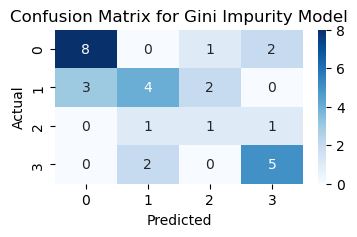

In [43]:
gini_model = DecisionTreeClassifier(criterion='gini', max_depth=5, min_samples_leaf=4, min_samples_split=2, random_state=42)

# Fit the model to the training data
gini_model.fit(X_train_scaled, y_train)

# Predict on the test set
y_pred_gini = gini_model.predict(X_test_scaled)

# Evaluate the model
print("Gini Impurity Model")
print("Accuracy:", accuracy_score(y_test, y_pred_gini))
print("Balanced accuracy:", balanced_accuracy_score(y_test, y_pred_gini))
print('Precision score:', precision_score(y_test, y_pred_gini, average='weighted'))
print('Recall score:', recall_score(y_test, y_pred_gini, average='weighted'))
print('F1 score:', f1_score(y_test, y_pred_gini, average='weighted'))



# Generate the confusion matrix
cm = confusion_matrix(y_test, y_pred_gini)

# Plot the confusion matrix
plt.figure(figsize=(4, 2))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=np.unique(y_test), yticklabels=np.unique(y_test))
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix for Gini Impurity Model')
plt.show()

### 1D.) Cross Validation 

In [96]:
from sklearn.model_selection import cross_val_score

# Perform cross-validation
cv_scores = cross_val_score(gini_model, X, y, cv=5)  # 5-fold cross-validation

# Print cross-validation scores
print("Cross-validation scores:", cv_scores)
print("Mean cross-validation score:", cv_scores.mean())
print("Standard deviation of cross-validation scores:", cv_scores.std())


Cross-validation scores: [0.6  0.7  0.45 0.7  0.55]
Mean cross-validation score: 0.6
Standard deviation of cross-validation scores: 0.09486832980505136


### 2A.) Entropy Model

In [97]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, balanced_accuracy_score, precision_score, recall_score, f1_score

# Create the Entropy model
entropy_model = DecisionTreeClassifier(criterion='entropy', random_state=42)

# Fit the model to the training data
entropy_model.fit(X_train_scaled, y_train)

# Predict on the test set
y_pred_entropy = entropy_model.predict(X_test_scaled)

# Evaluate the model
print("Entropy Model")
print("Accuracy:", accuracy_score(y_test, y_pred_entropy))
print("Balanced accuracy:", balanced_accuracy_score(y_test, y_pred_entropy))
print('Precision score:', precision_score(y_test, y_pred_entropy, average='weighted', zero_division=0))
print('Recall score:', recall_score(y_test, y_pred_entropy, average='weighted', zero_division=0))
print('F1 score:', f1_score(y_test, y_pred_entropy, average='weighted', zero_division=0))



Entropy Model
Accuracy: 0.5666666666666667
Balanced accuracy: 0.5905483405483406
Precision score: 0.6441077441077441
Recall score: 0.5666666666666667
F1 score: 0.5719047619047619


### 2B.) Grid Search on Entropy Model

In [98]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score, balanced_accuracy_score, precision_score, recall_score, f1_score

# Define the Decision Tree model with entropy criterion
dt_model = DecisionTreeClassifier(criterion='entropy', random_state=42)

# Define the parameter grid
param_grid = {
    'max_depth': [3, 5, 7, 10, 15],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

# Setup Grid Search with cross-validation
grid_search = GridSearchCV(estimator=dt_model, param_grid=param_grid, cv=5, scoring='accuracy', n_jobs=-1)

# Fit Grid Search
grid_search.fit(X_train_scaled, y_train)

# Get the best model from grid search
best_dt_model = grid_search.best_estimator_

# Predict on the test set
y_pred_best_dt = best_dt_model.predict(X_test_scaled)

# Evaluate the best model
print("Best Entropy Model")
print("Best parameters found: ", best_dt_model)


Best Entropy Model
Best parameters found:  DecisionTreeClassifier(criterion='entropy', max_depth=5, min_samples_leaf=4,
                       random_state=42)


### 2C.) Entropy Model with Parameter Tuning

Entropy Model
Accuracy: 0.6
Balanced accuracy: 0.6053391053391054
Precision score: 0.7033333333333334
Recall score: 0.6
F1 score: 0.6252136752136752


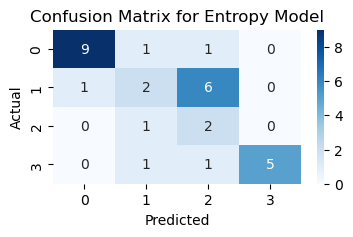

In [99]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, balanced_accuracy_score, precision_score, recall_score, f1_score

# Create the Entropy model
entropy_model = DecisionTreeClassifier(criterion='entropy', max_depth=5, min_samples_leaf=4, random_state=42)

# Fit the model to the training data
entropy_model.fit(X_train_scaled, y_train)

# Predict on the test set
y_pred_entropy = entropy_model.predict(X_test_scaled)


# Evaluate the model
print("Entropy Model")
print("Accuracy:", accuracy_score(y_test, y_pred_entropy))
print("Balanced accuracy:", balanced_accuracy_score(y_test, y_pred_entropy))
print('Precision score:', precision_score(y_test, y_pred_entropy, average='weighted', zero_division=0))
print('Recall score:', recall_score(y_test, y_pred_entropy, average='weighted', zero_division=0))
print('F1 score:', f1_score(y_test, y_pred_entropy, average='weighted', zero_division=0))



# Generate the confusion matrix
cm_entropy = confusion_matrix(y_test, y_pred_entropy)

# Plot the confusion matrix
plt.figure(figsize=(4,2))
sns.heatmap(cm_entropy, annot=True, fmt='d', cmap='Blues', xticklabels=np.unique(y_test), yticklabels=np.unique(y_test))
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix for Entropy Model')
plt.show() 

### 3A.) Random Forest

In [100]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, balanced_accuracy_score, precision_score, recall_score, f1_score

# Initialize the Random Forest model
rf_model = RandomForestClassifier(n_estimators=100, max_depth=10, random_state=42)

# Fit the model to the training data
rf_model.fit(X_train, y_train)

# Predict on the test data
y_pred_rf = rf_model.predict(X_test)

# Evaluate the model
print("Random Forest Model")
print("Accuracy:", accuracy_score(y_test, y_pred_rf))
print("Balanced accuracy:", balanced_accuracy_score(y_test, y_pred_rf))
print('Precision score:', precision_score(y_test, y_pred_rf, average='weighted', zero_division=0))
print('Recall score:', recall_score(y_test, y_pred_rf, average='weighted', zero_division=0))
print('F1 score:', f1_score(y_test, y_pred_rf, average='weighted', zero_division=0))


Random Forest Model
Accuracy: 0.6666666666666666
Balanced accuracy: 0.6082251082251082
Precision score: 0.7237179487179487
Recall score: 0.6666666666666666
F1 score: 0.6662393162393163


### 3B.) Grid Search on Random Forest

In [101]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score, balanced_accuracy_score, precision_score, recall_score, f1_score

# Define the Random Forest model
rf_model = RandomForestClassifier(random_state=42)

# Define the parameter grid
param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'bootstrap': [True, False]
}

# Setup Grid Search with cross-validation
grid_search = GridSearchCV(estimator=rf_model, param_grid=param_grid, cv=5, scoring='accuracy', n_jobs=-1)

# Fit Grid Search
grid_search.fit(X_train, y_train)

# Get the best model from grid search
best_rf_model = grid_search.best_estimator_


print("Best RF Model")
print("Best parameters found: ", best_rf_model)


Best RF Model
Best parameters found:  RandomForestClassifier(n_estimators=50, random_state=42)


### 3C.) Random Forest with Parameter Tuning

Random Forest Model
Accuracy: 0.6666666666666666
Balanced accuracy: 0.6082251082251082
Precision score: 0.7237179487179487
Recall score: 0.6666666666666666
F1 score: 0.6662393162393163


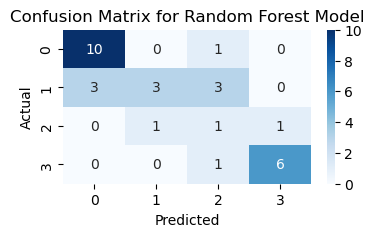

In [51]:
# Initialize the Random Forest model
rf_model = RandomForestClassifier(n_estimators=50, max_depth=10,random_state=42)

# Fit the model to the training data
rf_model.fit(X_train, y_train)

# Predict on the test data
y_pred_rf = rf_model.predict(X_test)

# Evaluate the model
print("Random Forest Model")
print("Accuracy:", accuracy_score(y_test, y_pred_rf))
print("Balanced accuracy:", balanced_accuracy_score(y_test, y_pred_rf))
print('Precision score:', precision_score(y_test, y_pred_rf, average='weighted', zero_division=0))
print('Recall score:', recall_score(y_test, y_pred_rf, average='weighted', zero_division=0))
print('F1 score:', f1_score(y_test, y_pred_rf, average='weighted', zero_division=0))

# Generate the confusion matrix
cm_rf = confusion_matrix(y_test, y_pred_rf)

# Plot the confusion matrix
plt.figure(figsize=(4,2))
sns.heatmap(cm_rf, annot=True, fmt='d', cmap='Blues', xticklabels=np.unique(y_test), yticklabels=np.unique(y_test))
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix for Random Forest Model')
plt.show()

### 4A.) Support Vector Model

In [102]:
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, balanced_accuracy_score, precision_score, recall_score, f1_score

# Define the SVM model
svm_model = SVC(random_state=42, probability=True)  # Set probability=True to use predict_proba for ROC curve

# Fit the model to the training data
svm_model.fit(X_train_scaled, y_train)

# Predict on the test data
y_pred_svm = svm_model.predict(X_test_scaled)

# Evaluate the model
print("Support Vector Machine Model")
print("Accuracy:", accuracy_score(y_test, y_pred_svm))
print("Balanced accuracy:", balanced_accuracy_score(y_test, y_pred_svm))
print('Precision score:', precision_score(y_test, y_pred_svm, average='weighted', zero_division=0))
print('Recall score:', recall_score(y_test, y_pred_svm, average='weighted', zero_division=0))
print('F1 score:', f1_score(y_test, y_pred_svm, average='weighted', zero_division=0))


Support Vector Machine Model
Accuracy: 0.7333333333333333
Balanced accuracy: 0.7193362193362193
Precision score: 0.8341269841269842
Recall score: 0.7333333333333333
F1 score: 0.7434559643255294


### 4B.)Grid Search Support Vector Model 

In [103]:
# Define the parameter grid for Grid Search
param_grid = {
    'C': [0.1, 1, 10, 100],             # Regularization parameter
    'kernel': ['linear', 'rbf', 'poly'], # Kernel type
    'gamma': [1,0.1,0.01,0.001]           
}

# Setup Grid Search with cross-validation
grid_search = GridSearchCV(estimator=svm_model, param_grid=param_grid, cv=5, scoring='accuracy', n_jobs=-1)

# Fit Grid Search
grid_search.fit(X_train, y_train)

# Get the best model from grid search
best_svm_model = grid_search.best_estimator_


print(best_svm_model)

SVC(C=1, gamma=1, kernel='linear', probability=True, random_state=42)


Support Vector Machine Model
Accuracy: 0.8
Balanced accuracy: 0.7698412698412699
Precision score: 0.8335897435897436
Recall score: 0.8
F1 score: 0.8014957264957264


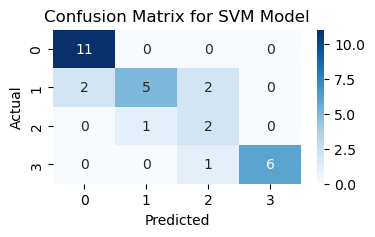

In [74]:
# Define the SVM model
svm_model = SVC(C=2, kernel='sigmoid', probability=True, random_state=42)  # Set probability=True to use predict_proba for ROC curve

# Fit the model to the training data
svm_model.fit(X_train_scaled, y_train)

# Predict on the test data
y_pred_svm = svm_model.predict(X_test_scaled)

# Evaluate the model
print("Support Vector Machine Model")
print("Accuracy:", accuracy_score(y_test, y_pred_svm))
print("Balanced accuracy:", balanced_accuracy_score(y_test, y_pred_svm))
print('Precision score:', precision_score(y_test, y_pred_svm, average='weighted', zero_division=0))
print('Recall score:', recall_score(y_test, y_pred_svm, average='weighted', zero_division=0))
print('F1 score:', f1_score(y_test, y_pred_svm, average='weighted', zero_division=0))


# Generate the confusion matrix
cm_svm = confusion_matrix(y_test, y_pred_svm)

# Plot the confusion matrix
plt.figure(figsize=(4,2))
sns.heatmap(cm_svm, annot=True, fmt='d', cmap='Blues', xticklabels=np.unique(y_test), yticklabels=np.unique(y_test))
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix for SVM Model')
plt.show()

In [104]:
# Cross-validation
cv_scores = cross_val_score(svm_model, X_train_scaled, y_train, cv=5, scoring='accuracy')

# Print cross-validation results
print("Cross-validation scores:", cv_scores)
print("Mean cross-validation score:", np.mean(cv_scores))
print("Standard deviation of cross-validation scores:", np.std(cv_scores))

Cross-validation scores: [0.57142857 0.64285714 0.64285714 0.5        0.92857143]
Mean cross-validation score: 0.6571428571428571
Standard deviation of cross-validation scores: 0.14568627181693672


  Features  Importance scores
3      AST           0.176667
5      CHE           0.140000
1      ALB           0.136667
0      Age           0.123333
7      GGT           0.106667
6     CREA           0.090000
8     PROT           0.083333
2      ALT           0.050000
4      BIL           0.030000


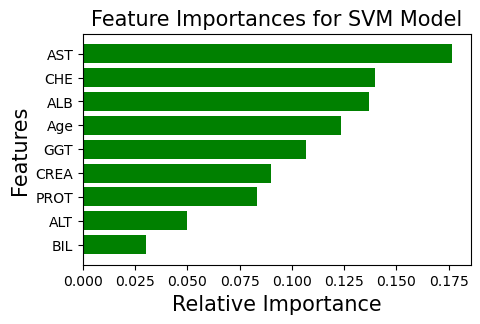

In [83]:
from sklearn.inspection import permutation_importance

# Compute permutation feature importance
perm_importance = permutation_importance(svm_model, X_test_scaled, y_test, n_repeats=10, random_state=42)

# DataFrame with feature names and their importance scores
features = X_train.columns  # column names from the training data
importances = perm_importance.importances_mean
tab = pd.DataFrame(list(zip(features, importances)), columns=['Features', 'Importance scores'])
tab = tab.sort_values(by='Importance scores', ascending=False)  # Sort by importance

# Print the DataFrame
print(tab)

# Visual comparison
plt.figure(figsize=(5,3))

# Sort indices by feature importance
indices = np.argsort(importances)
sorted_features = [features[i] for i in indices]
sorted_importances = [importances[i] for i in indices]

plt.barh(sorted_features, sorted_importances, align='center', color='g')
plt.xlabel('Relative Importance', fontsize=15)
plt.ylabel('Features', fontsize=15)
plt.title('Feature Importances for SVM Model', fontsize=15)
plt.savefig("feature_importances_svm.png")
plt.show()


### Model Analysis and Comparison
    


The Support Vector Model outperforms the Decision Trees and Random Forest models. Having an 80% accuracy demonstrates that it has moderate overall performance but could use improvement with techniques utilizing enhanced parameter tuning, ensemble methods, and/or using SMOTE to help balance the data set. Per the confusion matrix linked to the Support Vector Model, it demonstrated strength in being able to classify class 0 and class 3. This makes sense since the lab results of a person without Hepatitis C and a person WITH Hepatitis C (in liver failure) would depict a drastic difference. Therefore, the model could be rebuilt to perform binary classification instead of multi classification and would potentially yield better results. 